#I - Preparing Data :

---
Import of model libraries and others for the management of dataframes like pandas ... etc.

---

In [ ]:
import pandas as pd
import requests
import io
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import numpy as np 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn import tree
import pydotplus
from sklearn.tree import DecisionTreeClassifier
import matplotlib.image as pltimg
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from statistics import mode 
from sklearn.metrics import f1_score
# Downloading the csv file from  GitHub account

url = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv" 
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df = df[["age","sex","pO2_saturation","temperature","finding"]]
# Printing out the first 5 rows of the dataframe

df.head()

,age,sex,pO2_saturation,temperature,finding
0,65.0,M,NaN,NaN,Pneumonia/Viral/COVID-19
1,65.0,M,NaN,NaN,Pneumonia/Viral/COVID-19
2,65.0,M,NaN,NaN,Pneumonia/Viral/COVID-19
3,65.0,M,NaN,NaN,Pneumonia/Viral/COVID-19
4,52.0,F,NaN,NaN,Pneumonia/Viral/COVID-19


---

Lets list the data types for each column

---

In [ ]:
df.dtypes

age               float64
sex                object
pO2_saturation    float64
temperature       float64
finding            object
dtype: object

---
    
    
  Descriptive statistics include those that summarize the central tendency, dispersion, and shape of the distribution of a data set, excluding NaN values.

---

In [ ]:
df.describe()

,age,pO2_saturation,temperature
count,713.000000,119.000000,78.000000
mean,53.534362,78.475630,38.898718
std,16.949007,38.742573,6.494383
min,18.000000,20.000000,36.000000
25%,40.000000,55.000000,37.800000
50%,54.000000,85.000000,38.150000
75%,68.000000,95.000000,38.975000
max,94.000000,340.000000,95.000000


---

Let's see now how many Nan values foreach column.

---

In [ ]:
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

age
False    713
True     237
Name: age, dtype: int64

sex
False    870
True      80
Name: sex, dtype: int64

pO2_saturation
True     831
False    119
Name: pO2_saturation, dtype: int64

temperature
True     872
False     78
Name: temperature, dtype: int64

finding
False    950
Name: finding, dtype: int64



---

We gonna  remplace every missing value by their columns mean.

---

In [ ]:

#replacing the mean of age on missing values. 
avg_age_loss = df["age"].astype("float").mean(axis=0)
df["age"].replace(np.nan, avg_age_loss, inplace=True)

#replacing the mean of pO2_saturation on missing values. 
avg_pO2_saturation_loss = df["pO2_saturation"].astype("float").mean(axis=0)
df["pO2_saturation"].replace(np.nan, avg_pO2_saturation_loss, inplace=True)

#replacing the mean of temperature on missing values. 
avg_temperature_loss = df["temperature"].astype("float").mean(axis=0)
df["temperature"].replace(np.nan, avg_temperature_loss, inplace=True)

  ---
  
  Now, we remove the missing values left. and reset the index of data 

  ---

In [ ]:
df = df.dropna()
# reset index, because we droped 80 rows
df.reset_index(drop=True, inplace=True)


---

verify that we don't have any more missing values.

---

In [ ]:
print("is there missing values?  : \n", df.isnull().values.any())

is there missing values?  : 
 False


---
 
Change the categorical values to numerical on sex column.

---

In [ ]:
#using get_dummies to get numerical. 
dummy_variable_1 = pd.get_dummies(df["sex"])
dummy_variable_1.head()

,F,M
0,0,1
1,0,1
2,0,1
3,0,1
4,1,0


---

We have to concat new sex column to the data and removing the old sex column.

---

In [ ]:
# merge data frame "df" and "dummy_variable_1" 
df = pd.concat([dummy_variable_1,df], axis=1)

# drop original column "fuel-type" from "df"
df.drop("sex", axis = 1, inplace=True)

---

Changing the finding column by 0 and 1.

---

In [ ]:
m = df['finding'].count()
for i in range(0,m):
  if df['finding'][i]== "Pneumonia/Viral/COVID-19":
    df['finding'][i] = 1
  else :
    df['finding'][i] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


---

Let's see now the counts of 0 and 1.

---

In [ ]:
df['finding'].value_counts()

1    521
0    349
Name: finding, dtype: int64

---

The final prepared data.

---

In [ ]:
df.tail()


,F,M,age,pO2_saturation,temperature,finding
865,1,0,40.0,78.47563,38.898718,0
866,1,0,40.0,78.47563,38.898718,0
867,0,1,26.0,78.47563,38.898718,0
868,0,1,50.0,78.47563,38.898718,0
869,0,1,50.0,78.47563,38.898718,0


---

Visualizing data  distribution.

---

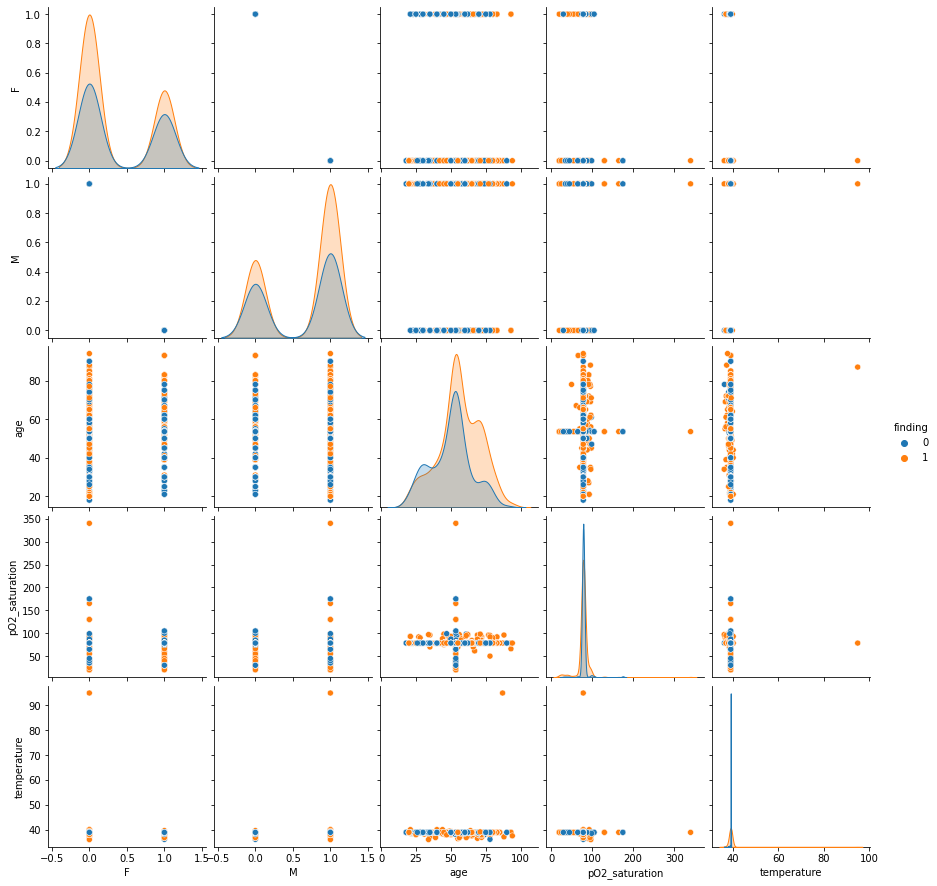

In [ ]:

sns.pairplot(df, hue='finding')

# II - Models : 

##1 - KNN

---

Splitting the data into train and test set.

---

In [ ]:
#X = pd.DataFrame(df.iloc[:,:-1])
#Y = pd.DataFrame(df.iloc[:,-1])
Xknn1 = df.iloc[:,:-1]
Yknn1 = df['finding']
x_train, x_test, y_train, y_test = train_test_split(Xknn1, Yknn1, test_size=0.20, random_state=4)
#make the y values be int
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 174
number of training samples: 696


---
calculating the error for every K to see the best choice.

---

In [ ]:
error_rate = []
# Might take some time
for i in range(1,40):
    #calling the model for k = i 
    knntest = KNeighborsClassifier(n_neighbors=i)
    #fitting the model
    knntest.fit(x_train,y_train)
    #making the prediction for x_test
    pred_i = knntest.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))

---

visualize the error by k.

---

Text(0, 0.5, 'Error Rate')

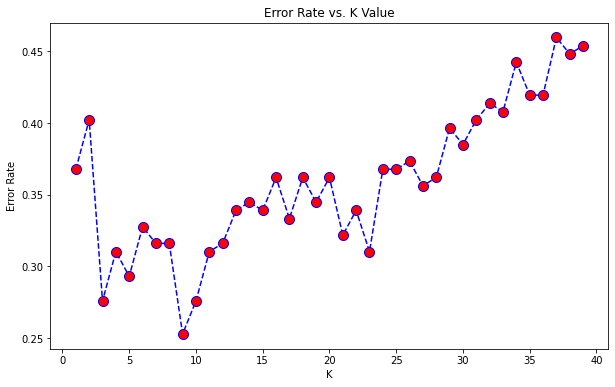

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

---

We call the model for k = 9  and we fit it.

---

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors = 9)
knn1.fit(x_train,y_train)
y_pred = knn1.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7471264367816092


---

display the precision, recall and the f1 score to see the performance.

---

In [ ]:

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


[[48 25]
 [19 82]]
              precision    recall  f1-score   support

           0       0.72      0.66      0.69        73
           1       0.77      0.81      0.79       101

    accuracy                           0.75       174
   macro avg       0.74      0.73      0.74       174
weighted avg       0.75      0.75      0.75       174



---

resplit the data using PCA for 2 to plot the decision boundry.

---

In [ ]:

#X = pd.DataFrame(df.iloc[:,:-1])
#Y = pd.DataFrame(df.iloc[:,-1])
Xvis = df.iloc[:,:-1]
Yvis = df['finding']
pca = PCA(n_components=2).fit_transform(Xvis)
x_train, x_test, y_train, y_test = train_test_split(pca, Yvis, test_size=0.20, random_state=4)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 174
number of training samples: 696


---

plotting the decision boundry.

---

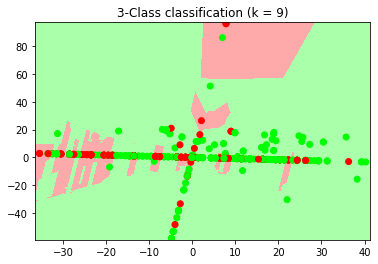

In [ ]:

knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(x_train, y_train)
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
# predict class using data and kNN classifier
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i)" % (9))
plt.show()

<h4> We repeat the same thing for other models </h4>

2 - SVM

In [ ]:
#X = pd.DataFrame(df.iloc[:,:-1])
#Y = pd.DataFrame(df.iloc[:,-1])
Xsvm = df.iloc[:,:-1]
Ysvm = df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(Xsvm, Ysvm, test_size=0.20, random_state=4)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 174
number of training samples: 696


In [ ]:
clf = svm.SVC()
clf.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svm_ypred = clf.predict(x_test)

In [ ]:
print(confusion_matrix(y_test,svm_ypred))
print(classification_report(y_test,svm_ypred))

[[11 62]
 [14 87]]
              precision    recall  f1-score   support

           0       0.44      0.15      0.22        73
           1       0.58      0.86      0.70       101

    accuracy                           0.56       174
   macro avg       0.51      0.51      0.46       174
weighted avg       0.52      0.56      0.50       174



In [ ]:
Xvis = df.iloc[:,:-1]
Yvis = df['finding']
pca = PCA(n_components=2).fit_transform(Xvis)
x_train, x_test, y_train, y_test = train_test_split(pca, Yvis, test_size=0.20, random_state=4)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 174
number of training samples: 696


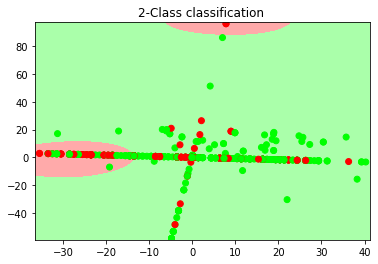

In [ ]:

clf = svm.SVC()
clf.fit(x_train, y_train)
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
# predict class using data and kNN classifier
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification " )
plt.show()

##3 - Decision Tree : 

In [ ]:
Xtree = df.iloc[:,:-1]
Ytree = df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(Xtree, Ytree, test_size=0.20, random_state=4)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 174
number of training samples: 696


---

let's display the decision tree.

---

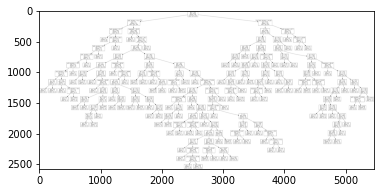

In [ ]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(x_train, y_train)
data = tree.export_graphviz(dtree, out_file=None, feature_names=x_train.columns)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png('mydecisiontree.png')

img=pltimg.imread('mydecisiontree.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
tree_ypred = dtree.predict(x_test)

In [ ]:
print(confusion_matrix(y_test,tree_ypred))
print(classification_report(y_test,tree_ypred))

[[54 19]
 [32 69]]
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        73
           1       0.78      0.68      0.73       101

    accuracy                           0.71       174
   macro avg       0.71      0.71      0.70       174
weighted avg       0.72      0.71      0.71       174



In [ ]:
Xvis = df.iloc[:,:-1]
Yvis = df['finding']
pca = PCA(n_components=2).fit_transform(Xvis)
x_train, x_test, y_train, y_test = train_test_split(pca, Yvis, test_size=0.20, random_state=4)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 174
number of training samples: 696


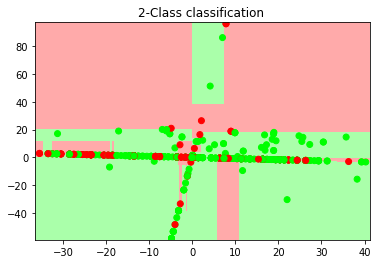

In [ ]:

#clf = svm.SVC()
dtree.fit(x_train, y_train)
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
# predict class using data and kNN classifier
Z = dtree.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification " )
plt.show()

## 4 - Random Forest Classifier

In [ ]:
Xrf = df.iloc[:,:-1]
Yrf = df['finding']
x_train, x_test, y_train, y_test = train_test_split(Xrf, Yrf, test_size=0.20, random_state=4)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 174
number of training samples: 696


In [ ]:
rf=RandomForestClassifier()
rf.fit(x_train,y_train)
rf_ypred = rf.predict(x_test)
print(confusion_matrix(y_test,rf_ypred))
print(classification_report(y_test,rf_ypred))

[[53 20]
 [30 71]]
              precision    recall  f1-score   support

           0       0.64      0.73      0.68        73
           1       0.78      0.70      0.74       101

    accuracy                           0.71       174
   macro avg       0.71      0.71      0.71       174
weighted avg       0.72      0.71      0.71       174



In [ ]:
Xvis = df.iloc[:,:-1]
Yvis = df['finding']
pca = PCA(n_components=2).fit_transform(Xvis)
x_train, x_test, y_train, y_test = train_test_split(pca, Yvis, test_size=0.20, random_state=4)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 174
number of training samples: 696


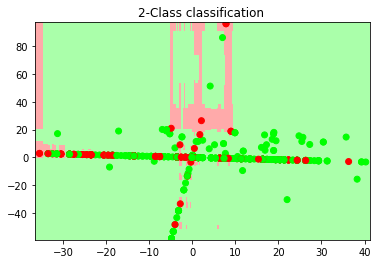

In [ ]:

rf1=RandomForestClassifier()
rf1.fit(x_train, y_train)
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
# predict class using data and kNN classifier
Z = rf1.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification " )
plt.show()

## 4 - Logistic Regression : 

In [ ]:
Xlr = df.iloc[:,:-1]
Ylr = df['finding']
x_train, x_test, y_train, y_test = train_test_split(Xlr, Ylr, test_size=0.20, random_state=4)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 174
number of training samples: 696


In [ ]:


lr = LogisticRegression(solver='lbfgs',random_state=0)
lr.fit(x_train,y_train)
lr_ypred = lr.predict(x_test)
print(confusion_matrix(y_test,lr_ypred))
print(classification_report(y_test,lr_ypred))

[[20 53]
 [18 83]]
              precision    recall  f1-score   support

           0       0.53      0.27      0.36        73
           1       0.61      0.82      0.70       101

    accuracy                           0.59       174
   macro avg       0.57      0.55      0.53       174
weighted avg       0.58      0.59      0.56       174



In [ ]:
Xvis = df.iloc[:,:-1]
Yvis = df['finding']
pca = PCA(n_components=2).fit_transform(Xvis)
x_train, x_test, y_train, y_test = train_test_split(pca, Yvis, test_size=0.20, random_state=4)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 174
number of training samples: 696


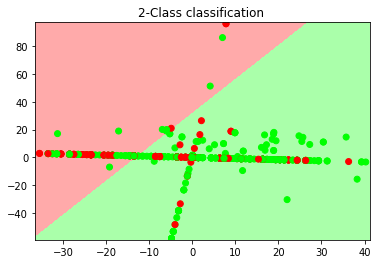

In [ ]:

#clf = svm.SVC()
lr.fit(x_train, y_train)
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
# predict class using data and kNN classifier
Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification " )
plt.show()

#   III - models  Comparison ( pipelines )

---

Now we have to choose the best model by using pipeline.

---

knn pipeline

In [ ]:
pipeline_knn=Pipeline([('knn_classifier',KNeighborsClassifier(n_neighbors = 9))])

svm pipeline

In [ ]:
pipeline_svm=Pipeline([('svm_classifier',svm.SVC())])

decision tree pipeline

In [ ]:
pipeline_dt=Pipeline([('dt_classifier',DecisionTreeClassifier())])

random forest pipeline  


In [ ]:
pipeline_rfc=Pipeline([('rfc_classifier',RandomForestClassifier())])

logistic regression pipeline 

In [ ]:

pipeline_lr=Pipeline([('lr_classifier',LogisticRegression())])


---

resplit the data to test and train.

---

In [ ]:
X = df.iloc[:,:-1]
Y = df['finding']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=4)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 174
number of training samples: 696


---

we gonna fit the data for every model in the pipeline 

---

In [ ]:
pipelines = [pipeline_knn, pipeline_svm, pipeline_dt, pipeline_rfc, pipeline_lr]

best_f1=0.0
best_classifier=0
best_pipeline=""

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = { 0 : 'knn', 1: 'svm', 2: 'Decision Tree', 3: 'RandomForest', 4: 'Logistic Regression'}

# Fit the pipelines
for pipe in pipelines:
	pipe.fit(x_train, y_train)

---

Displaying the f1 score for every model to see the best one.

---

In [ ]:
for i,model in enumerate(pipelines):
    y_pred=model.predict(x_test)
    print("{} F1 score: {}".format(pipe_dict[i],f1_score(y_test, y_pred, average='weighted')))

knn F1 score: 0.7453549324238979
svm F1 score: 0.4981825005864415
Decision Tree F1 score: 0.7087984908414315
RandomForest F1 score: 0.7200005379225815
Logistic Regression F1 score: 0.5577524272417332


---

Displaying the best model.

---

In [ ]:
for i,model in enumerate(pipelines):
    y_pred=model.predict(x_test)
    if f1_score(y_test, y_pred, average='weighted')>best_f1:
        best_f1=f1_score(y_test, y_pred, average='weighted')
        best_pipeline=model
        best_classifier=i
print('Classifier with best f1 score : {}'.format(pipe_dict[best_classifier]))

Classifier with best f1 score : knn


# IV - Ensemble Learning

---

let's have a random x to predict if has covid or not.

---

In [ ]:
x = np.array([1, 0, 40, 78, 30])
x = x.reshape(-1, len(x_train.columns))
x

array([[ 1,  0, 40, 78, 30]])

In [ ]:
pred = []

---

The list pred has every predicted value foreach model.

---

In [ ]:
for i,model in enumerate(pipelines):
    pred.append(model.predict(x)[0])
pred

[0, 1, 1, 1, 0]

---

this function return the most common value on  a list using the mode.

---

In [ ]:
def most_common(List): 
    return(mode(List)) 

---

The predicted value.

---

In [ ]:

print(most_common(pred)) 

1
